# Final

In [1]:
import secrets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from itertools import combinations
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics.pairwise import euclidean_distances
from cvxopt import matrix, solvers

solvers.options['show_progress'] = False
sns.set_context("paper")

In [2]:
data_path = Path().resolve().parent / "data"

In [3]:
# Random seed for reproducibility
# secrets.randbits(128) # 208905213533139122735706682150229709525
rng = np.random.default_rng(208905213533139122735706682150229709525)

In [4]:
def get_data(data_path, labels, n_train_label, n_test_label, rng):
    """
    Returns train and test data for some labels.

    Parameters
    ----------

    data_path: pathlib.PosixPath
        Path of datasets

    labels: list
        Digits from MNIST set

    n_train_label: int
        Number of train samples for each label

    n_test_label: int
        Number of test samples for each label

    rng: numpy.random._generator.Generator
        Seed for reproducibility

    Returns
    -------
    tuple of np.array
        X_train, y_train, X_test, y_test

    """
    train_list = []  # Auxiliary list of train datasets
    for f_train in data_path.glob("train*.txt"):
        if f_train.stem.removeprefix("train") not in map(str, labels):
            continue  # Skips labels
        raw_train = np.loadtxt(f_train)
        if n_train_label is not None:
            # Sample
            indices_train = rng.choice(raw_train.shape[0], n_train_label, replace=False)
            raw_train = raw_train[indices_train, :]
        target_train = raw_train[:, [0]]  # Target values, i.e. digit
        features_train = raw_train[:, 1:] / 255
        train_list.append(np.hstack((target_train, features_train)))
    train_data = np.vstack(train_list)  # Concatenate train datasets

    test_list = []
    for f_test in data_path.glob("test*.txt"):
        if f_test.stem.removeprefix("test") not in map(str, labels):
            continue  # Skip labels
        raw_test = np.loadtxt(f_test)
        if n_test_label is not None:
            # Sample
            indices_test = rng.choice(raw_test.shape[0], n_test_label, replace=False)
            raw_test = raw_test[indices_test, :]
        target_test = raw_test[:, [0]]
        features_test = raw_test[:, 1:] / 255
        test_list.append(np.hstack((target_test, features_test)))
    test_data = np.vstack(test_list)

    X_train = train_data[:, 1:]
    y_train = train_data[:, 0].astype(int)
    X_test = test_data[:, 1:]
    y_test = test_data[:, 0].astype(int)
    return X_train, y_train, X_test, y_test

In [5]:
def filter_data(X, y, labels):
    mask = np.isin(y, labels)
    X_new = X[mask, :]
    y_new = y[mask]
    return X_new, y_new

1. SVM

In [6]:
def radial_basis(X1, X2, gamma):
    K = np.exp(-gamma * euclidean_distances(X1, X2, squared=True))
    return K


class SVM_binary():
    def __init__(self, C, gamma):
        self.C = C
        self.gamma = gamma
        self.X_train = None
        self.y_train = None

    def train(self, X_train, y_train):
        n_train = X_train.shape[0]
        self.X_train = X_train
        self.y_train = y_train
        K_train = radial_basis(self.X_train, self.X_train, self.gamma)
        M = matrix(np.outer(self.y_train, self.y_train) * K_train)  # Quadratic
        e = matrix(np.ones(shape=(n_train, 1), dtype=float))  # Linear
        G = matrix(np.identity(n=n_train, dtype=float))  # Inequality constraint
        h = matrix(self.C * e)  # RHS inequality constraint
        A = matrix(self.y_train.reshape(1, -1).astype(float))  # Equality constraint
        b = matrix(0.0)  # RHS equality constraint
        self.sol = solvers.qp(M, -e, G, h, A, b)  # Quadratic solver
        self.alpha = np.array(self.sol["x"]).flatten()
        self.I = np.argwhere(self.alpha > 0).flatten()
        # i_0_idx = self.alpha[(0 < self.alpha) & (self.alpha < self.C)].argmax()
        # self.b = (
        #     np.sum(
        #         self.y_train[self.I] *  self.alpha[self.I] * K_train[self.I, i_0_idx]
        #     )
        #     - self.y_train[i_0_idx]
        # )
        self.b = np.mean(
            np.sum(
                self.y_train[self.I] *  self.alpha[self.I] * K_train[np.ix_(self.I, self.I)],
                axis=1
            ) - self.y_train[self.I]
        )


    def predict(self, X_test, return_class_number=False):
        n_test = X_test.shape[0]
        K_test = radial_basis(self.X_train, X_test, self.gamma)
        class_number = (
            np.sum(
                self.y_train[self.I, np.newaxis]
                * self.alpha[self.I, np.newaxis]
                * K_test[self.I, :],
                axis=0
            )
            - self.b * np.ones(shape=(n_test))
        )
        if return_class_number:
            # Only return class number
            return class_number
        else:
            y_pred = np.where(class_number > 0, 1, -1)
            return y_pred

    def accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.mean(y_pred == y_test)

In [7]:
gamma = 0.03
C = 100

2. Classification 3 vs 6

In [8]:
labels_36 = np.array([3, 6])
n_train_label = 500  # each label
n_test_label = 500  # each label
X_train_36, y_train_36, X_test_36, y_test_36 = get_data(
    data_path,
    labels_36,
    n_train_label,
    n_test_label,
    rng
)
min_label = np.min(labels_36)
y_train_bin_36 = np.where(y_train_36 == min_label, -1, 1)  # y_i \in {-1, 1}
y_test_bin_36 = np.where(y_test_36 == min_label, -1, 1)  # y_i \in {-1, 1}

In [9]:
svm_36 = SVM_binary(C=C, gamma=gamma)
svm_36.train(X_train_36, y_train_bin_36)

3. Accuracy 3 vs 6

In [10]:
svm_36.accuracy(X_test_36, y_test_bin_36)

0.99

4. Reduction of training examples

In [15]:
factors = [0.75, 0.90, 0.95]
n_train = X_train_36.shape[0]

In [16]:
test_accuracy_36 = {}
for factor in factors:
    n_per_label = int((n_train - n_train * factor) / len(labels_36))
    X_train_tmp_list = []
    y_train_tmp_list = []
    # Sample each label
    for label in labels_36:
        mask_train = y_train_36 == label
        y_train_tmp = y_train_36[mask_train]
        X_train_tmp = X_train_36[mask_train, :]
        idx = rng.choice(y_train_tmp.shape[0], n_per_label, replace=False)
        X_train_tmp_list.append(X_train_tmp[idx, :])
        y_train_tmp_list.append(y_train_tmp[idx])
    X_train = np.vstack(X_train_tmp_list)
    y_train = np.concatenate(y_train_tmp_list)
    y_train_bin = np.where(y_train == min_label, -1, 1)
    y_test_bin = np.where(y_test_36 == min_label, -1, 1)
    try:
        svm = SVM_binary(C=C, gamma=gamma)
        svm.train(X_train, y_train_bin)
        test_accuracy_36[factor] = svm.accuracy(X_test_36, y_test_bin)
    except Exception as e:
        print(f"Factor {factor} Error: {e}")

In [17]:
test_accuracy_36

{0.75: 0.998, 0.9: 0.981, 0.95: 0.982}

5. Reduction of pixeles uniformly

In [18]:
n_features = X_train_36.shape[1]
test_accuracy_pixel_36 = {}
for factor in factors:
    n_features_new = int(n_features * (1 - factor))  # Number of pixels
    idx = np.linspace(0, n_features, num=n_features_new, endpoint=False, dtype=int)
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train_36[:, idx], y_train_bin_36)
    test_accuracy_pixel_36[factor] = svm.accuracy(X_test_36[:, idx], y_test_bin_36)

In [19]:
test_accuracy_pixel_36

{0.75: 0.967, 0.9: 0.96, 0.95: 0.932}

6. SVD

In [20]:
def svd(X):
    n_train, n_features = X.shape
    U, D_array, Vh = np.linalg.svd(X, full_matrices=True)
    n_singular = len(D_array)
    D = np.zeros(shape=(n_train, n_features))
    D[:n_singular, :n_singular] = np.diag(D_array)
    return U, D, Vh.conj().T

In [21]:
n_features = X_train_36.shape[1]
U_36, D_36, V_36 = svd(X_train_36)
test_accuracy_svd_36 = {}
for factor in factors:
    n_features_new = int(n_features * (1 - factor))
    X_train = U_36 @ D_36[:, :n_features_new]
    X_test = X_test_36 @ V_36[:, :n_features_new]
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train, y_train_bin_36)
    test_accuracy_svd_36[factor] = svm.accuracy(X_test, y_test_bin_36)

In [22]:
test_accuracy_svd_36

{0.75: 0.99, 0.9: 0.987, 0.95: 0.987}

7. Even vs Odd

In [23]:
labels_0to9 = np.arange(0, 10)
X_train_0to9, y_train_0to9, X_test_0to9, y_test_0to9 = get_data(
    data_path,
    labels_0to9,
    100,
    100,
    rng
)
y_train_0to9_even_odd = np.where(y_train_0to9 % 2 == 0, -1, 1)  # even = -1, odd = 1
y_test_0to9_even_odd = np.where(y_test_0to9 & 2 == 0, -1, 1)

In [24]:
svm_0to9_even_odd = SVM_binary(C=C, gamma=gamma)
svm_0to9_even_odd.train(X_train_0to9, y_train_0to9_even_odd)
svm_0to9_even_odd.accuracy(X_test_0to9, y_test_0to9_even_odd)

0.503

8. one vs the rest

In [25]:
test_accuracy_one_vs_rest = {}
for label in labels_0to9:
    y_train_bin_label = np.where(y_train_0to9 == label, 1, -1)
    y_test_bin_label = np.where(y_test_0to9 == label, 1, -1)
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train_0to9, y_train_bin_label)
    test_accuracy_one_vs_rest[label] = svm.accuracy(X_test_0to9, y_test_bin_label)
test_accuracy_one_vs_rest

{0: 0.959,
 1: 0.97,
 2: 0.802,
 3: 0.717,
 4: 0.748,
 5: 0.777,
 6: 0.805,
 7: 0.755,
 8: 0.752,
 9: 0.718}

9. Multiclass with classification number

In [26]:
svm_multi_pred_dict = {}
svm_clas_numbers_dict = {}
for label in labels_0to9:
    y_train_0to9_bin_target = np.where(y_train_0to9 == label, 1, -1)
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_test_0to9, y_train_0to9_bin_target)
    y_pred_bin = svm.predict(X_test_0to9)
    class_numbers = svm.predict(X_test_0to9, return_class_number=True)
    y_pred = np.where(y_pred_bin == 1, label, -1)
    svm_multi_pred_dict[label] = y_pred
    svm_clas_numbers_dict[label] = class_numbers

In [51]:
svm_multi_pred = pd.DataFrame(svm_multi_pred_dict)
svm_clas_numbers = pd.DataFrame(svm_clas_numbers_dict)
# Select higher class number from positive hyper-planes
y_pred_0to9_classnumber = svm_clas_numbers.where(svm_multi_pred.ne(-1)).idxmax(axis=1)
all_null_pred = svm_clas_numbers.loc[svm_multi_pred.loc[lambda x: x.eq(-1).all(axis=1)].index, :].abs().idxmax(axis=1)
y_pred_0to9_classnumber.loc[all_null_pred.index] = all_null_pred.values

In [52]:
accuracy_classnumber = np.mean(y_test_0to9 == y_pred_0to9_classnumber)
accuracy_classnumber

0.945

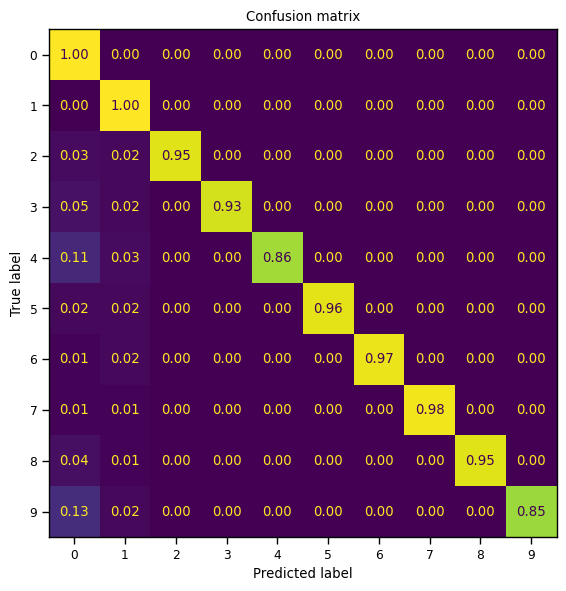

In [32]:
# Confusion matrix - row normalization
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_0to9,
    y_pred_0to9_classnumber,
    normalize="true",
    values_format=".2f",
    ax=ax
)
ax.images[0].colorbar.remove()
ax.set_title(f"Confusion matrix")
fig.tight_layout()
# fig.savefig(
    # f"final_confusion_matrix_vote_fulldata.png",
    # dpi=300
# )

10. Multiclass with voting

In [33]:
svm_pairs_pred = {}
for label_1, label_2 in combinations(labels_0to9, 2):
    map_dict = {label_1: -1, label_2: 1}
    map_inv_dict = {v: k for k, v in map_dict.items()}
    X_train, y_train = filter_data(X_train_0to9, y_train_0to9, [label_1, label_2])
    y_train_bin = np.vectorize(map_dict.get)(y_train)
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train, y_train_bin)
    y_pred_bin = svm.predict(X_test_0to9)
    y_pred = np.vectorize(map_inv_dict.get)(y_pred_bin)
    svm_pairs_pred[(label_1, label_2)] = y_pred
pair_pred_df = pd.DataFrame(svm_pairs_pred.values()).T

In [34]:
y_pred_0to9_vote = pair_pred_df.mode(axis=1).loc[:, 0].astype(int).to_numpy()
accuracy_vote = np.mean(y_test_0to9 == y_pred_0to9_vote)
accuracy_vote

0.908

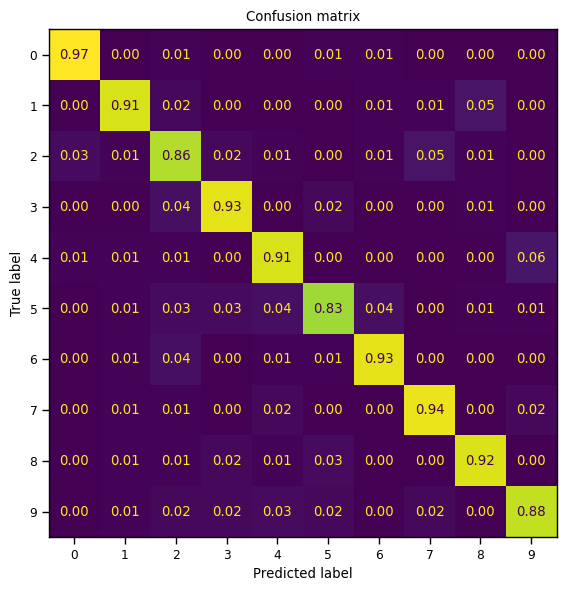

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_0to9,
    y_pred_0to9_vote,
    normalize="true",
    values_format=".2f",
    ax=ax
)
ax.images[0].colorbar.remove()
ax.set_title(f"Confusion matrix")
fig.tight_layout()
fig.savefig(
    f"final_confusion_matrix_vote.png",
    dpi=300
)